In [12]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import copy
from scipy.stats.stats import pearsonr   
import seaborn as sns
sns.set()

In [70]:
import model
import utilities as ut

In [8]:
def get_news(h, h0, cons, cons_, phi, r, xi):
    return (-h + h0*np.tanh((cons-cons_)/cons_) + xi) - phi*r + h

def get_kd(kd_old, h, h_old, beta1, beta2):
    return kd_old + beta1*(h-h_old) + beta2*h_old

def get_working_hours(c,u,G,I,g):
    return u/(g*c) + G*(u*I)/(2*c*g*(c-G*I))

def get_feedback(x,x0,xmin,xmax,a): 
    return 1-0.5*(np.tanh(a*(x-x0))*(xmax-xmin)+xmax+xmin)

def get_production(y_old, n_old, k_old , rho, z, tau_y):
    return z*(k_old**rho)*(n_old**(1-rho))

def get_wage(u_old, n_old, k_old , rho, z, tau_u):
    return (1-rho)*z*(k_old**rho)*(n_old**(-rho))

In [74]:
# SET PARAMETERS
params = dict(
    etaZ=0.2, sigmaZ=0.0, zbar=1,
    inflation=0.01, interest=0.01, 
    k0=6.0, xmin=0.0, xmax=1.0, theta=10.0,
    c1=1e-5, c2=2e-4,
    depreciation=0.2, gamma=1
)

# INITIAL VALUES
start = dict(
    z=1, k=1, ks=1, kd=1, s=0, 
    cons=1, labour=1, bonds=1,
    feedback=0, wage=1, xi=0
)
start = np.array([v for _,v in start.items()])

T = 1e3

In [75]:
df = model.simulate(start, params, T)

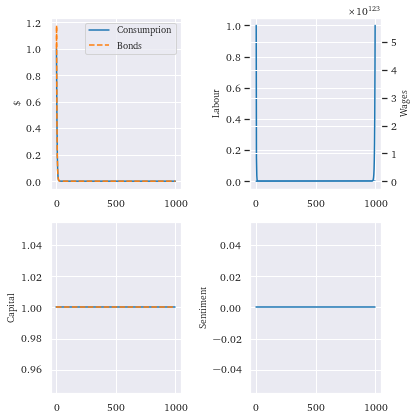

In [77]:
fig, axs= plt.subplots(ncols=2, nrows=2)

axs[0,0].plot(df.consumption, label='Consumption')
axs[0,0].plot(df.bond, label='Bonds')
axs[0,0].legend()
axs[0,0].set_ylabel(r'\$')

axs[0,1].plot(df.labour)
axs[0,1].set_ylabel('Labour')

ax = axs[0,1].twinx()
ax.plot(df.wage)
ax.set_ylabel('Wages')

axs[1,0].plot(df.ks)
axs[1,0].plot(df.kd)
axs[1,0].set_ylabel('Capital')

axs[1,1].plot(df.sentiment)
axs[1,1].set_ylabel('Sentiment')

fig.tight_layout()
plt.show()

In [11]:
T = 1000
### SET PARAMETERS (At what timescale? Annual?)###

inflation = 0.01
interest = 0.01
gamma = 1.0 # What is this?
phi = 1.2 # News strength of interest rate?
gamma_r = gamma*(1+interest)
depr = 0.2
beta1 = 0.4 # ???
beta2 = 0.4 # ???
news_old = 1.0
news_ = []

### SET FEEDBACK PARAMETERS ###
theta  = 5
k0 = 6 # Reference capital level is static - not good
xmax = 1
xmin = 0.

### SET NOISY TERMS ###
etaZ = 0.2
sigmaZ = 0.8
zbar = 1

### INITIALISE VECTORS ###
consumption = []
investments = []
labour = []
bonds = []
feed = []
wage = []
capital = []
technology = []

### SET VARIABLES AT TIME T0 ###

u_ = 1
lab_ = 1
b_ = 1

cons_ = 1
xi_ = 0
news = 0
news_ = 0
ks_= 1
kd_ = 0.1
k_ = 5
y_ = 1
u_ = 1

for t in range(T):
    
    xi = etaZ*xi_ + np.sqrt(1-etaZ**2)*np.random.normal(0,sigmaZ)
    z  = zbar*np.exp(xi_)
    
    income = u_*lab_ + b_/(1+inflation) 
    feedback = get_feedback(news_,k0,xmin,xmax,theta)
    ks = (1-feedback)*income

    news = get_news(1,1,k, k_,0.1,interests,0)#(1-b)*((k-k_)/k_ + np.random.uniform(-.1,.1)) + b*news_
    #kd = get_kd(kd_, news, news_, beta1, beta2)
    
    k = ks + (1-depr)*k_ 
    news = get_news(1,1,k, k_,0.1,interest,xi)
    x0 = z*np.sqrt(2*k)
    x1 = feedback*income
    x2 = gamma_r
    
    cons = bisection(x0,x1,x2, 1e-2)
    
    #print([z,x0,x1,x2])
    
    prod = cons

    lab = (cons**2)/(4*k*(z**2))
    u = 0.5*cons/lab
    
    b = (feedback*income - cons)*(1+interest)
    
    technology.append(z)
    capital.append(k)
    consumption.append(cons)
    labour.append(lab)
    bonds.append(b)
    investments.append(max(min(kd,ks),0))
    feed.append(feedback)
    wage.append(u)
    
    cons_ =np.copy(cons)
    ks_ =np.copy(ks)
    kd_ =np.copy(k)
    b_ += np.copy(b)
    u_ = np.copy(u)
    lab_ = np.copy(lab)
    xi_ = np.copy(xi)
    news_ = np.copy(news)
    prod_ = np.copy(prod)
    k_ = np.copy(k)

NameError: name 'kd' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(np.log(consumption))
ax.plot(np.log(capital))
ax.plot(feed)
#ax[0].plot(np.log(labour))
#ax[0].plot(np.log(bonds))
#ax.plot(np.log(consumption))

#ax[0].set_xlim([750,1250])


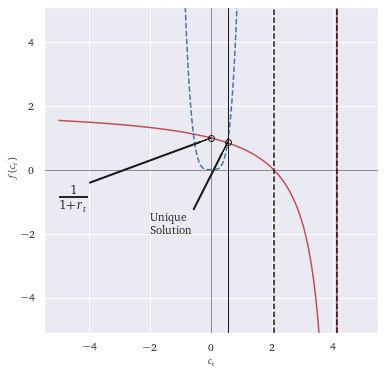

In [59]:
g = 4.12691520115423
gamma = 1.0
r = 0.01
x0 = 0.3195333487091828
nx = 10000
x = np.linspace(-5,5,nx)

ut.plot_settings()
fig, ax = plt.subplots(figsize = (6,6))

# AXES
ax.axhline(0, color='k', linewidth=.5)
ax.axvline(0, color='k', linewidth=.5)

# RHS & LHS
ax.plot(x, model.rhs(x, g, gamma, r), color = 'r')
ax.plot(x, model.lhs(x, x0), color = 'b')

# Solution point
cons = model.bisection(x0, g, gamma, r, 1e-4)
g_ = model.rhs(cons, g, gr)

# Key Sections
ax.axvline(g, linestyle='--', color='k')
ax.axvline(g/2, linestyle='--', color='k')
ax.axvline(cons, linewidth=1, color='k')

# Mark the Solution
circle_rad = 3  # This is the radius, in points
ax.plot(cons, g_, 'o', ms=circle_rad * 2, mec='k', mfc='none', mew=1)
ax.annotate('Unique\nSolution', xy=(cons, g_), xytext=(-2, -2),
            arrowprops=dict(width=1, color='k', headwidth=0, shrinkB=circle_rad * 1.2)
)

# Mark the consumption = 0 point
circle_rad = 3  # This is the radius, in points
ax.plot(0, 1/(1+r), 'o', ms=circle_rad * 2, mec='k', mfc='none', mew=1)
ax.annotate(r'$\frac{1}{1+r_t}$', xy=(0, 1/(1+r)), xytext=(-5, -1), fontsize=20,
            arrowprops=dict(width=1, color='k', headwidth=0, shrinkB=circle_rad * 1.2)
)

ax.set_ylim([-10,10])
ax.set_ylim([-5.1,5.1])
ax.set_xlabel(r'$c_t$')
ax.set_ylabel(r'$f(c_t)$')

plt.savefig('figures/test.pdf', format='pdf', bbox_inches = 'tight', transparent=True)

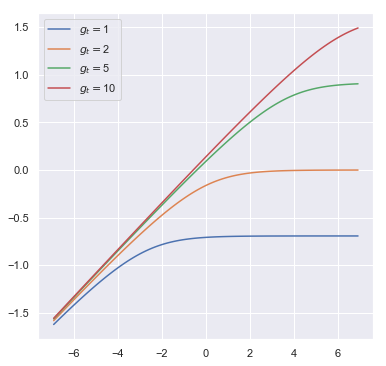

In [579]:
z = 1
#g = 5
gr = 1

fig, ax = plt.subplots(1,1,figsize = (6,6))

capital = np.logspace(-3,3,100)

for g in [1,2,5,10]:
    cons = []
    for k in capital:
        cons.append(bisection(z*np.sqrt(2*k),g,gr, 1e-4))
    ax.plot(np.log(capital), np.log(cons), label= r'$g_t = $' + str(g))
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.legend()
#plt.plot(capital, g-np.asarray(cons))
plt.savefig('/Users/fedemoro/Desktop/sols.eps', format='eps',bbox_inches = 'tight')#,transparent=True)